In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
from numba import njit
from sklearn.metrics import roc_auc_score
from catboost import CatBoostClassifier
import matplotlib.pyplot as plt
from scipy.stats import kstest
import numpy.random
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
sns.set(style="darkgrid")

In [3]:
data_path = Path('data')

In [4]:
df_train = pd.read_csv(data_path / 'train.csv')

In [5]:
df_test = pd.read_csv(data_path / 'test.csv')

In [6]:
df_train.rename(columns={"opened_position_qty ": "opened_position_qty"}, inplace=True)
df_test.rename(columns={"opened_position_qty ": "opened_position_qty"}, inplace=True)

In [7]:
y, df = df_train.pop('y'), df_train

In [8]:
df.head(10)

,id,last_price,mid,opened_position_qty,closed_position_qty,transacted_qty,d_open_interest,bid1,bid2,bid3,...,bid1vol,bid2vol,bid3vol,bid4vol,bid5vol,ask1vol,ask2vol,ask3vol,ask4vol,ask5vol
0,0,3842.4,3842.6,NaN,NaN,103.0,0,3842.4,3842.0,3841.8,...,8,1,6,14,6,6,1,1,10,2
1,1,3842.8,3843.4,6.0,49.0,55.0,-43,3843.0,3842.8,3842.4,...,7,6,11,1,6,1,4,4,1,13
2,2,3844.0,3844.3,7.0,77.0,84.0,-69,3843.8,3843.6,3843.2,...,3,1,4,21,12,1,16,10,4,9
3,3,3843.8,3843.4,3.0,34.0,37.0,-30,3843.0,3842.8,3842.4,...,10,13,12,2,4,2,7,1,2,11
4,4,3843.2,3843.1,3.0,38.0,41.0,-35,3842.8,3842.4,3842.0,...,14,12,2,2,4,1,3,1,11,15
5,5,3843.6,3844.2,12.0,17.0,29.0,-5,3843.8,3843.4,3843.2,...,1,6,1,2,17,1,12,15,10,3
6,6,3843.6,3844.3,2.0,37.0,39.0,-34,3843.8,3843.4,3843.2,...,1,7,1,1,17,11,15,10,3,9
7,7,3844.8,3843.5,4.0,24.0,28.0,-20,3843.2,3843.0,3842.8,...,1,2,17,1,12,2,12,7,16,10
8,8,3843.4,3843.7,2.0,30.0,32.0,-28,3843.4,3843.2,3843.0,...,1,1,3,17,1,1,2,6,8,18
9,9,3844.0,3843.4,3.0,12.0,15.0,-9,3843.0,3842.8,3842.6,...,1,17,3,12,2,7,1,2,7,8


In [9]:
df_test.head()

,id,last_price,mid,opened_position_qty,closed_position_qty,transacted_qty,d_open_interest,bid1,bid2,bid3,...,bid1vol,bid2vol,bid3vol,bid4vol,bid5vol,ask1vol,ask2vol,ask3vol,ask4vol,ask5vol
0,592380,5178.4,5178.3,1.0,11.0,12.0,-10,5178.2,5178.0,5177.8,...,3,16,3,1,1,1,4,1,5,2
1,592381,5133.0,5132.9,1.0,0.0,1.0,1,5132.8,5132.6,5132.4,...,1,2,2,1,10,4,8,1,1,1
2,592382,5177.4,5178.0,2.0,0.0,2.0,2,5177.2,5176.8,5176.6,...,8,18,1,1,6,7,4,1,2,5
3,592383,5093.6,5093.9,0.0,2.0,2.0,-1,5093.2,5093.0,5092.8,...,8,5,4,3,1,1,1,11,6,2
4,592384,5189.2,5189.2,NaN,NaN,0.0,0,5188.8,5188.6,5188.4,...,1,5,1,3,3,3,2,1,3,4


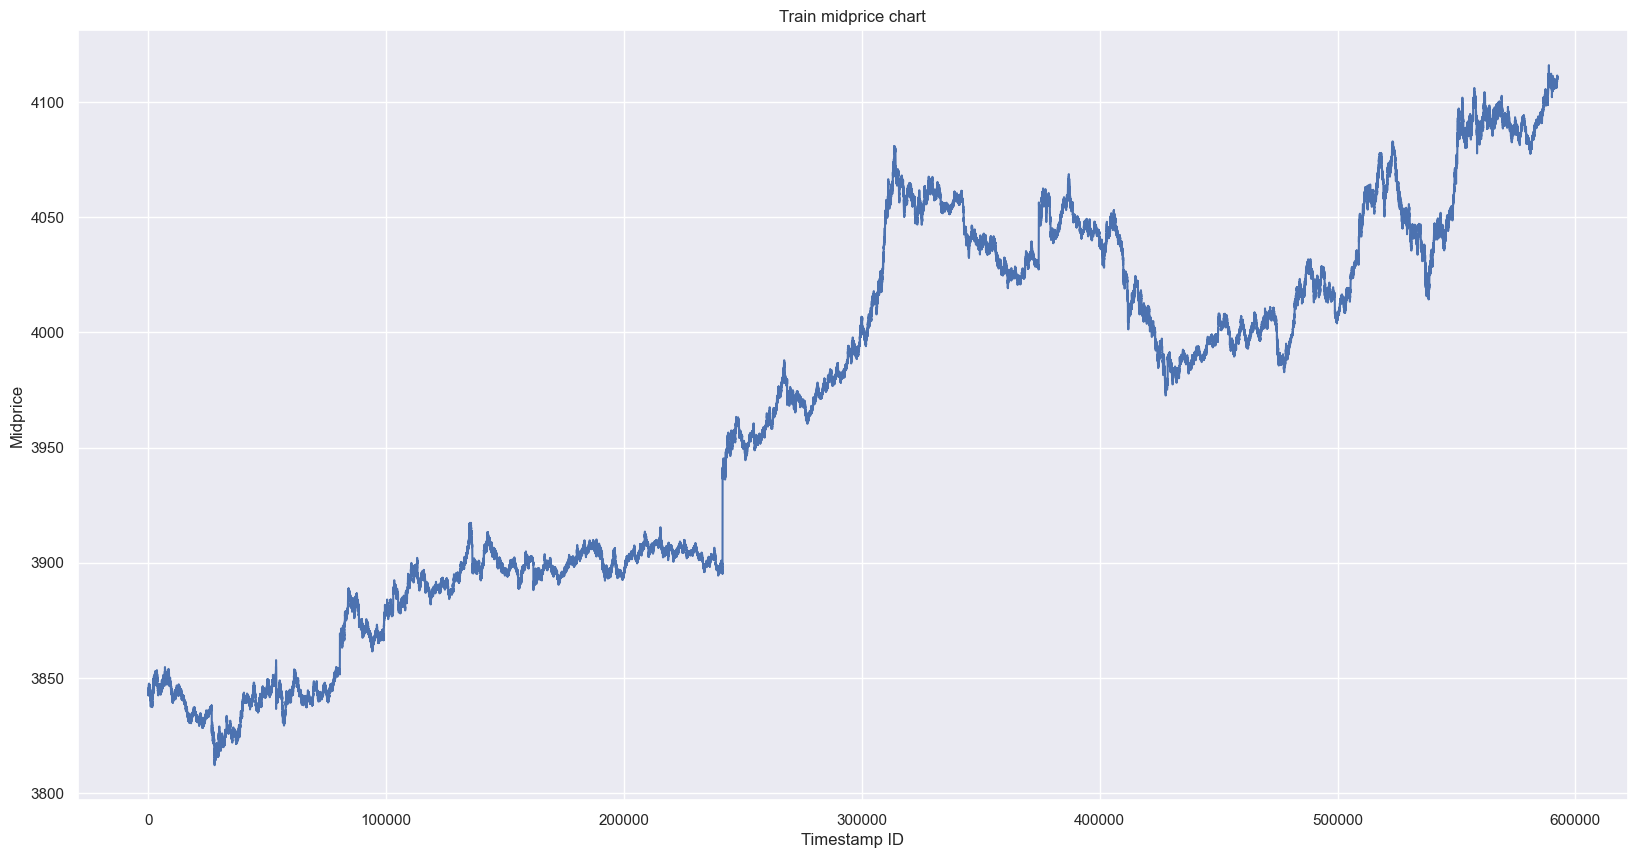

In [10]:
fig, ax = plt.subplots(figsize=(20,10))
plt.plot(df.id, df.mid)
plt.title('Train midprice chart')
plt.xlabel('Timestamp ID')
plt.ylabel('Midprice')
plt.show()

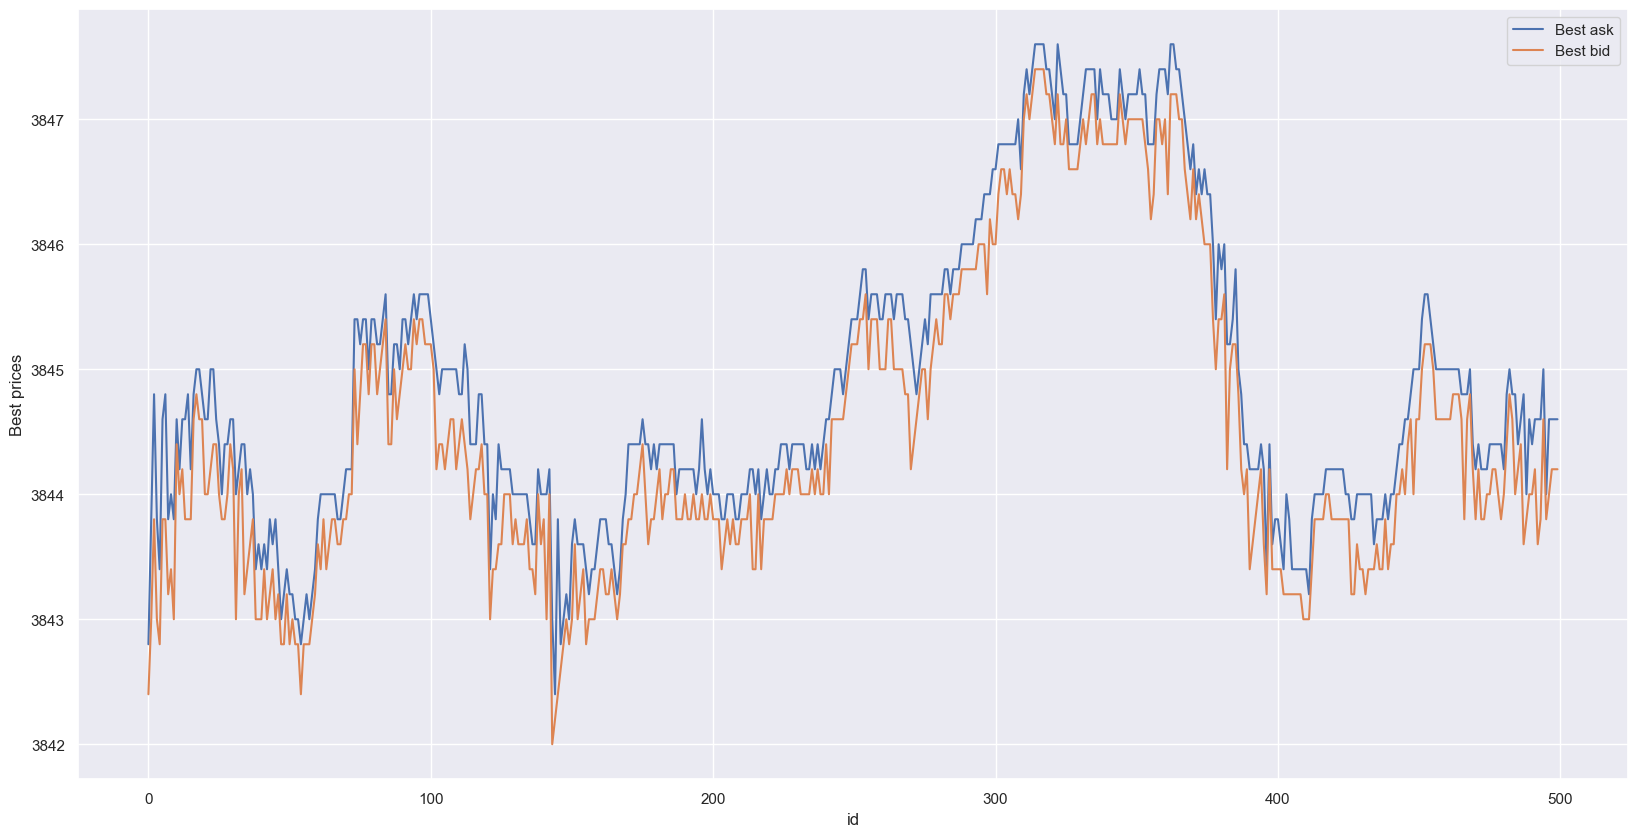

In [11]:
start_time_frame = 0
end_time_frame = 500
fig, ax = plt.subplots(figsize=(20,10))
sns.lineplot(df.iloc[start_time_frame:end_time_frame], x='id', y='ask1', ax=ax, label='Best ask')
sns.lineplot(df.iloc[start_time_frame:end_time_frame], x='id', y='bid1', ax=ax, label='Best bid')
plt.ylabel('Best prices')
plt.show()

In [12]:
def best_bid_quote(data):
    return data.bid1 * data.bid1vol

def best_ask_quote(data):
    return data.ask1 * data.ask1vol

class Formulas:

    def vimba(data):
        return data.bid1vol / (data.bid1vol + data.ask1vol)

    def quote_vimba(data):
        bid_quote = best_bid_quote(data)
        ask_quote = best_ask_quote(data)
        return bid_quote / (bid_quote + ask_quote)

    def spread(data):
        return data.ask1 - data.bid2

    def last_take_ask_diff(data):
        return data.ask1 - data.last_price

    def last_take_bid_diff(data):
        return data.last_price - data.bid1

    def interest_imbalance(data):
        return (data.opened_position_qty / data.transacted_qty).replace([np.inf, -np.inf], 1)

    def open_interest_imbalance(data):
        return (data.opened_position_qty / data.d_open_interest).replace([np.inf, -np.inf], 1)

class Features:
    def compute(data):
        feats = [feat(data) for feat in Formulas.__dict__.values() if callable(feat)]
        cols = [feat.__name__ for feat in Formulas.__dict__.values() if callable(feat)]
        feats = pd.concat(feats, axis=1)
        feats.columns = cols
        return feats

In [13]:
feats = Features.compute(df)
feats.head()

,vimba,quote_vimba,spread,last_take_ask_diff,last_take_bid_diff,interest_imbalance,open_interest_imbalance
0,0.571429,0.571403,0.8,0.4,0.0,NaN,NaN
1,0.875000,0.874977,1.0,1.0,-0.2,0.109091,-0.139535
2,0.750000,0.749951,1.2,0.8,0.2,0.083333,-0.101449
3,0.833333,0.833304,1.0,0.0,0.8,0.081081,-0.100000
4,0.933333,0.933324,1.0,0.2,0.4,0.073171,-0.085714


In [14]:
test_feats = Features.compute(df_test)
test_feats.head()

,vimba,quote_vimba,spread,last_take_ask_diff,last_take_bid_diff,interest_imbalance,open_interest_imbalance
0,0.750000,0.749993,0.4,0.0,0.2,0.083333,-0.1
1,0.200000,0.199994,0.4,0.0,0.2,1.000000,1.0
2,0.533333,0.533256,2.0,1.4,0.2,1.000000,1.0
3,0.888889,0.888862,1.6,1.0,0.4,0.000000,-0.0
4,0.250000,0.249971,1.0,0.4,0.4,NaN,NaN


In [15]:
feats.describe()

,vimba,quote_vimba,spread,last_take_ask_diff,last_take_bid_diff,interest_imbalance,open_interest_imbalance
count,592380.000000,592380.000000,592380.000000,592380.000000,592380.000000,419920.000000,354186.000000
mean,0.498875,0.498856,0.622263,0.191762,0.192669,0.372631,0.559110
std,0.235983,0.235982,0.218876,0.235759,0.235628,0.373718,1.111442
min,0.009901,0.009900,0.400000,-1.800000,-2.600000,0.000000,-37.000000
25%,0.333333,0.333298,0.400000,0.000000,0.000000,0.000000,0.000000
50%,0.500000,0.499975,0.600000,0.200000,0.200000,0.333333,1.000000
75%,0.666667,0.666656,0.800000,0.400000,0.400000,0.666667,1.000000
max,0.990000,0.990000,4.800000,3.800000,4.000000,1.000000,36.000000


In [16]:
test_feats.describe()

,vimba,quote_vimba,spread,last_take_ask_diff,last_take_bid_diff,interest_imbalance,open_interest_imbalance
count,191859.000000,191859.000000,191859.000000,191859.000000,191859.000000,138203.000000,117141.000000
mean,0.498269,0.498247,0.900650,0.287206,0.289551,0.386622,0.595141
std,0.218727,0.218727,0.396125,0.382409,0.381505,0.372083,1.109685
min,0.010204,0.010204,0.400000,-2.800000,-2.800000,0.000000,-22.000000
25%,0.333333,0.333308,0.600000,0.000000,0.000000,0.000000,0.000000
50%,0.500000,0.499971,0.800000,0.200000,0.200000,0.333333,1.000000
75%,0.666667,0.666649,1.200000,0.600000,0.600000,0.666667,1.000000
max,0.990196,0.990195,7.600000,4.400000,6.200000,1.000000,22.000000


In [17]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

In [18]:
X_train, X_test, y_train, y_test = train_test_split(feats, y, test_size=0.3, shuffle=False)
X_train.dropna(inplace=True)
y_train = y_train.loc[X_train.index]
X_test.dropna(inplace=True)
y_test = y_test.loc[X_test.index]

lm_clf = LogisticRegression()
lm_clf.fit(X_train, y_train)

y_test_pred_proba = lm_clf.predict_proba(X_test)[:, 1]
y_train_pred_proba = lm_clf.predict_proba(X_train)[:, 1]

print('train score:', roc_auc_score(y_train, y_train_pred_proba))
print('test score:', roc_auc_score(y_test, y_test_pred_proba))

train score: 0.6474865790196539
test score: 0.6391906483890109


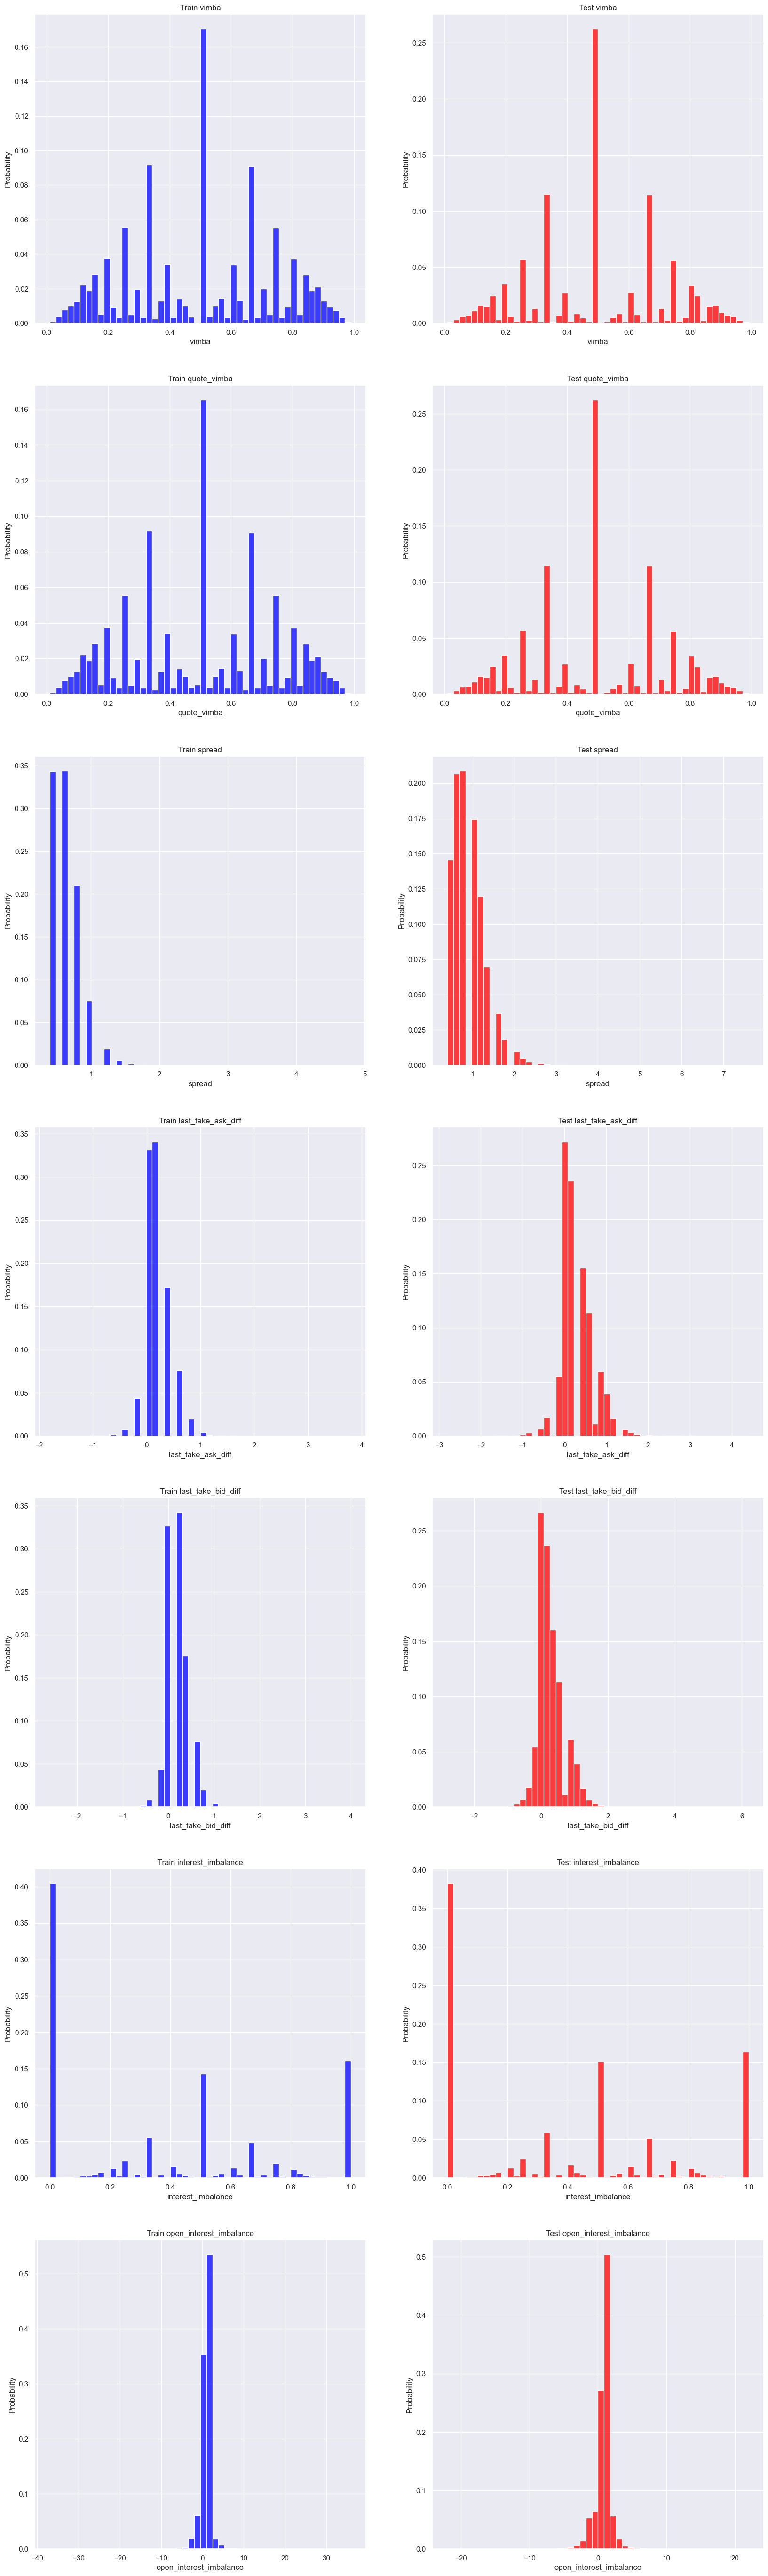

In [19]:
fig, axs = plt.subplots(feats.shape[1], 2, figsize=(20, feats.shape[1] * 10))

for i, feat in enumerate(feats.columns):
    sns.histplot(feats[feat], color="blue", ax=axs[i, 0], bins=50, stat='probability').set(title=f'Train {feat}')
    sns.histplot(test_feats[feat], color="red", ax=axs[i, 1], bins=50, stat='probability').set(title=f'Test {feat}')

plt.show()

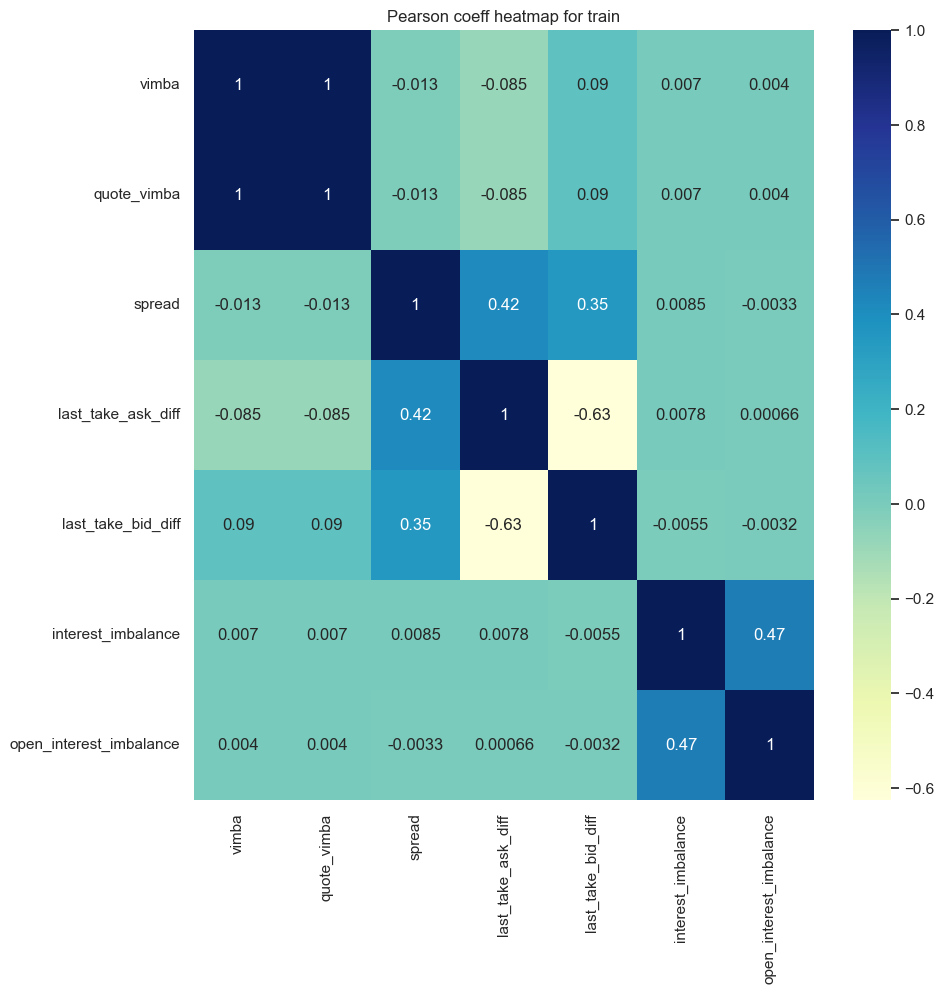

In [20]:
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(feats.corr(), cmap="YlGnBu", annot=True, ax=ax).set(title='Pearson coeff heatmap for train')
plt.show()

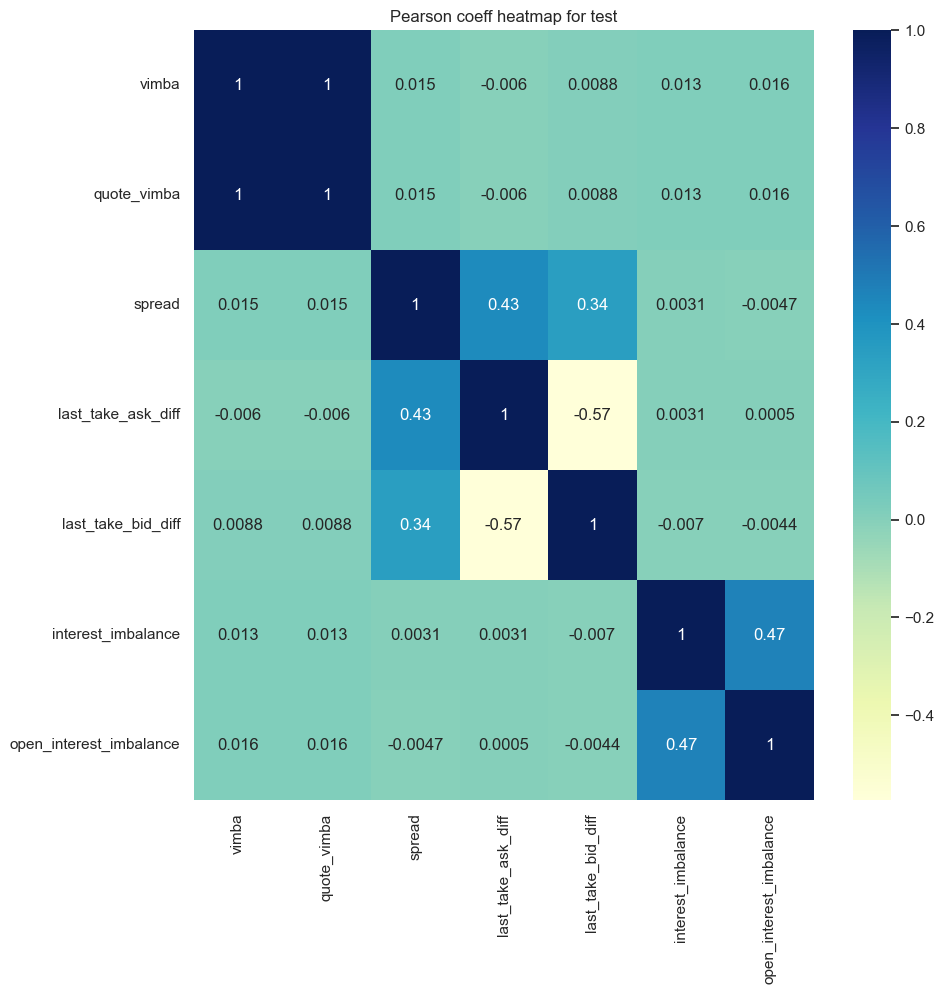

In [21]:
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(test_feats.corr(), cmap="YlGnBu", annot=True, ax=ax).set(title='Pearson coeff heatmap for test')
plt.show()

In [22]:
boost_clf = CatBoostClassifier(
    iterations=100,
    learning_rate=0.15,
    depth=5,
    eval_metric='AUC',
    logging_level='Silent',
    thread_count=5,
    task_type='CPU',
    has_time=True
)

In [23]:
boost_clf.fit(X_train, y_train, eval_set=(X_test, y_test), plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [24]:
roc_auc_score(y_train, boost_clf.predict_proba(X_train)[:, 1])

0.6582172684613262

In [25]:
roc_auc_score(y_test, boost_clf.predict_proba(X_test)[:, 1])

0.6460348375323962

In [26]:
boost_clf = CatBoostClassifier(
    iterations=100,
    learning_rate=0.15,
    depth=5,
    eval_metric='AUC',
    logging_level='Silent',
    thread_count=5,
    task_type='CPU',
    has_time=True
)

params = {
    "iterations": [50],
    "thread_count" : [5],
    "has_time" : [True, False],
    "depth": np.arange(3, 10),
    "rsm" : np.arange(0.2, 1.2, 0.2)
}

boost_clf.grid_search(params, X=X_train, y=y_train, cv=5, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
0:	loss: 0.6521938	best: 0.6521938 (0)	total: 577ms	remaining: 39.8s
Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
1:	loss: 0.6532804	best: 0.6532804 (1)	total: 1.22s	remaining: 41.6s
Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
2:	loss: 0.6537819	best: 0.6537819 (2)	total: 1.8s	remaining: 40.2s
Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
3:	loss: 0.6536779	best: 0.6537819 (2)	total: 2.37s	remaining: 39.2s
Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
4:	loss: 0.6544130	best: 0.6544130 (4)	total: 3.01s	rem

{'params': {'has_time': True,
  'thread_count': 5,
  'depth': 8,
  'iterations': 50,
  'rsm': 1.0},
 'cv_results': defaultdict(list,
             {'iterations': [0,
               1,
               2,
               3,
               4,
               5,
               6,
               7,
               8,
               9,
               10,
               11,
               12,
               13,
               14,
               15,
               16,
               17,
               18,
               19,
               20,
               21,
               22,
               23,
               24,
               25,
               26,
               27,
               28,
               29,
               30,
               31,
               32,
               33,
               34,
               35,
               36,
               37,
               38,
               39,
               40,
               41,
               42,
               43,
               44,
        

In [27]:
kspvalues = {feat : kstest(feats[feat], test_feats[feat]).pvalue for feat in feats.columns}

In [28]:
pd.DataFrame(kspvalues, index=[0]).T

,0
vimba,1.047806e-277
quote_vimba,0.000000e+00
spread,0.000000e+00
last_take_ask_diff,0.000000e+00
last_take_bid_diff,0.000000e+00
interest_imbalance,2.282187e-19
open_interest_imbalance,1.107704e-20
